# Dual-PRF outlier identification and correction
Uses circular mean to identify outliers and corrects them based on the deviation from the local median velocity.
The methodology is less affected by neighbouring outliers and can be applied in the presence of global aliasing.

Algorthim reference: **Patricia Altube**, Bech, J., Argemí, O., Rigo, T., Pineda, N., Collis, S., & Helmus, J. (n.d.). Correction of dual-PRF Doppler velocity outliers in the presence of aliasing. Journal of Atmospheric and Oceanic Technology, 0(0), null. http://doi.org/10.1175/JTECH-D-16-0065.1

PyART reference: JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 

Adpated for Australian operation radars by [**Joshua Soderholm**](https://github.com/uq-crg)

In [2]:
import os.path
import glob
import matplotlib.pyplot as plt
import pylab as plb
import matplotlib as mpl
import pyart
import numpy as np
import scipy as sp
import numpy.ma as ma
import re
import h5py

from pylab import *
from scipy import ndimage

%matplotlib inline

## Auxiliary function: 
Adds dummy columns (with NA values) in range for wrapping radar image edges when applying the convolutions.

In [3]:
def dummy_cols(data, kernel, val='nan'):
    
    # Image boundaries are wrapped for calculation of convolution
    # NA values (zeroes/nan) are added in range
    
    c = (np.asarray(kernel.shape)-1)/2
    add_cols = ceil(c[1])
    dummy_cols = np.zeros((data.shape[0], add_cols.astype(int)))
    
    if val=='nan':
        dummy_cols[:] = np.NAN
    else:
        dummy_cols[:] = val
        
    # Add dummy columns
    data_out = np.hstack((data, dummy_cols))
    
    return add_cols, data_out
    

## Auxiliary function: 
Returns an array with the number of local neighbours with a valid velocity value.

In [4]:
def local_valid(mask, kernel=np.ones((3,3))):
    
    ## Calculate number of local neighbours with valid value ##
    
    # Modified mask (NA values addition)
    mask_tmp = (~mask).astype(int)
    ncols, mask_tmp = dummy_cols(mask_tmp, kernel, val=0)
    
    # Convolve with kernel to calculate number of valid neighbours
    valid_tmp = ndimage.convolve(mask_tmp, kernel, mode='wrap')
    
    # Remove added values
    valid = valid_tmp[:, : (valid_tmp.shape[1] - ncols)]
    
    return valid.astype(int)
    

## Auxiliary function: 
Returns an array with the dual-PRF factor corresponding to each gate.

In [5]:
def primary_vel(dim, Nprf, prf_flag=None, prf_odd=None):
    
    ## Construct array with the dual-PRF factor corresponding to each gate ##
    # Flag 0 indicates low PRF and flag 1 indicates high PRF
    
    flag_vec = np.ones(dim[0])
    
    if (prf_flag is None) & (prf_odd is not None) :
        if prf_odd==0:
            flag_vec[::2] = 0
        elif prf_odd==1:
            flag_vec[1::2] = 0
    else:
        flag_vec = prf_flag
        
    flag_vec = flag_vec - 1
    flag_vec[flag_vec<0] = 1
        
    flag_arr = np.transpose(np.tile(flag_vec, (dim[1], 1)))
    Nprf_arr = flag_arr + Nprf
    
    return Nprf_arr

## Auxiliary function: 
Returns an array with either the mean or the median velocity calculated for the neighbouring gates in a user-defined window.

In [6]:
def ref_val(data, mask, kernel, method='median'):
    
    dummy_val=0
    Nval_arr = np.ones(mask.shape)
    
    if method=='mean':
        Nval_arr = local_valid(mask, kernel=kernel)
        dummy_data = data*(~mask).astype(int)
        
    if method=='median':
        dummy_val='nan'
        dummy_data = np.where(np.logical_not(mask), data, np.nan)
        

    ncols, data_conv = dummy_cols(dummy_data, kernel, val=dummy_val)
    
    if method=='mean':
        conv_arr = ndimage.convolve(data_conv, weights=kernel, mode='wrap')
        
    if method=='median':
        conv_arr = ndimage.generic_filter(data_conv, np.nanmedian, footprint=kernel, mode='wrap')
    
    # Remove added columns and divide by weight
    conv_arr = conv_arr[:, : (conv_arr.shape[1] - ncols)]
    ref_arr = conv_arr/Nval_arr
    
    return ref_arr

## Identification function using circular statistics:
Returns an array with the reference velocities to be used in the correction function and a mask-like array indicating the dual-PRF outliers. Reference velocities are the median velocity calculated for the neighbouring gates after identified outliers have been removed.

In [7]:
def outlier_detector_cmean(np_ma, Vny, Nprf_arr, Nmin=2):
    
    data = np_ma.data
    mask = np_ma.mask
    
    f_arr = np.ones(Nprf_arr.shape)
    f_arr[np.where(Nprf_arr==np.min(Nprf_arr))] = -1
    Vny_arr = Vny/Nprf_arr
    
    kH, kL = np.zeros((5,5)), np.zeros((5,5))
    kH[1::2] = 1
    kL[::2] = 1
     
    # Array with the number of valid neighbours at each point
    Nval_arr_H = local_valid(mask, kernel=kH)
    Nval_arr_L = local_valid(mask, kernel=kL)
    
    # Convert to angles and calculate trigonometric variables
    ang_ma = (np_ma*pi/Vny)
    cos_ma = ma.cos(ang_ma*Nprf_arr)
    sin_ma = ma.sin(ang_ma*Nprf_arr)
    
    # Average trigonometric variables in local neighbourhood
    dummy_cos = cos_ma.data*(~mask).astype(int)
    dummy_sin = sin_ma.data*(~mask).astype(int)
    
    ncols, cos_conv = dummy_cols(dummy_cos, kH, val=0)
    ncols, sin_conv = dummy_cols(dummy_sin, kH, val=0)
    
    cos_sumH = ndimage.convolve(cos_conv, weights=kH, mode='wrap')
    cos_sumL = ndimage.convolve(cos_conv, weights=kL, mode='wrap')
    
    sin_sumH = ndimage.convolve(sin_conv, weights=kH, mode='wrap')
    sin_sumL = ndimage.convolve(sin_conv, weights=kL, mode='wrap')
    
    # Remove added columns
    cos_sumH = cos_sumH[:, : (cos_sumL.shape[1] - ncols)]
    cos_sumL = cos_sumL[:, : (cos_sumL.shape[1] - ncols)]
    sin_sumH = sin_sumH[:, : (sin_sumL.shape[1] - ncols)]
    sin_sumL = sin_sumL[:, : (sin_sumL.shape[1] - ncols)]
    
    # Average angle in local neighbourhood
    cos_avgH_ma = ma.array(data=cos_sumH, mask=mask)/Nval_arr_H
    cos_avgL_ma = ma.array(data=cos_sumL, mask=mask)/Nval_arr_L
    sin_avgH_ma = ma.array(data=sin_sumH, mask=mask)/Nval_arr_H
    sin_avgL_ma = ma.array(data=sin_sumL, mask=mask)/Nval_arr_L
      
    BH = ma.arctan2(sin_avgH_ma, cos_avgH_ma)
    BL = ma.arctan2(sin_avgL_ma, cos_avgL_ma)
    
    # Average velocity ANGLE of neighbours (reference ANGLE for outlier detection):
    angref_ma = f_arr*(BL-BH)
    angref_ma[angref_ma<0] = angref_ma[angref_ma<0] + 2*pi
    angref_ma[angref_ma>pi] = - (2*pi - angref_ma[angref_ma>pi])
    angobs_ma = ma.arctan2(ma.sin(ang_ma), ma.cos(ang_ma))
    
    # Detector array (minimum ANGLE difference between observed and reference):
    diff = angobs_ma - angref_ma
    det_ma = (Vny/pi)*ma.arctan2(ma.sin(diff), ma.cos(diff))
    
    out_mask = np.zeros(det_ma.shape)
    out_mask[abs(det_ma)>0.8*Vny_arr] = 1
    out_mask[(Nval_arr_H<Nmin)|(Nval_arr_L<Nmin)] = 0
    
    # CORRECTION
    
    # Convolution kernel
    kernel = np.ones(kH.shape)
    
    new_mask = (mask) | (out_mask.astype(bool))
    
    # Array with the number of valid neighbours at each point (outliers removed)
    Nval_arr = local_valid(new_mask, kernel=kernel)
    
    out_mask[Nval_arr<Nmin] = 0
    
    ref_arr = ref_val(data, new_mask, kernel, method='median')
    ref_ma = ma.array(data=ref_arr, mask=mask)
    
    return ref_ma, out_mask

## Correction function:
This is the main function. 
Estimates the unwrap number that results in the minimum deviation between the gate velocity and the corresponding reference velocity. Returns a masked array with the corrected velocities.

In [49]:
def correct_dualPRF_cmean(radar, field='velocity', 
                   corr_method='median', Nmin=2):
    
    v_ma     = radar.fields[field]['data']
    vcorr_ma = v_ma.copy()
    out_mask = np.zeros(v_ma.shape)
    
    # Dual-PRF parameters
    Vny     = radar.instrument_parameters['nyquist_velocity']['data'][0] #Nyquist velocity
    prf_odd = radar.instrument_parameters['prf_odd']['data'][0] #odd flag for identifying the PRF of the radial
    f       = radar.instrument_parameters['prt_ratio']['data'][0] 
    Nprf    = int(round(1/(f-1))) #dual-PRF factor
    
    # Array with the primary Nyquist velocity corresponding to each bin
    Nprf_arr = primary_vel(v_ma.shape, Nprf, prf_odd=prf_odd)
    Vny_arr = Vny/Nprf_arr

    for nsweep, sweep_slice in enumerate(radar.iter_slice()):
        
        v0 = v_ma[sweep_slice] # velocity field
        vp = Vny_arr[sweep_slice] # primary velocities
        nprfp = Nprf_arr[sweep_slice] # dual-PRF factors
        
        ref, out_mask[sweep_slice] = outlier_detector_cmean(v0, Vny, nprfp, Nmin=Nmin)
                 
        # Convert non-outliers to zero for correction procedure  
        v0_out = v0*out_mask[sweep_slice]
        vp_out = vp*out_mask[sweep_slice]
        ref_out = ref*out_mask[sweep_slice]
        vp_out_L = vp_out.copy() # Only low PRF outliers
        vp_out_L[nprfp==Nprf] = 0
        
        dev = ma.abs(v0_out-ref_out)
        nuw = np.zeros(v0.shape) # Number of unwraps (initialisation)
        
        for ni in range(-Nprf, (Nprf+1)):
            
            # New velocity values for identified outliers
            if abs(ni)==Nprf:
                vcorr_out = v0_out + 2*ni*vp_out_L
            else:
                vcorr_out = v0_out + 2*ni*vp_out
            
            # New deviation for new velocity values
            dev_tmp = ma.abs(vcorr_out-ref_out)
            # Compare with previous
            delta = dev-dev_tmp
            # Update unwrap number
            nuw[delta>0] = ni
            # Update corrected velocity and deviation
            vcorr_out_tmp = v0_out + 2*nuw*vp_out
            dev = ma.abs(vcorr_out_tmp-ref_out)
            
        # Corrected velocity field
        vcorr_ma[sweep_slice] = v0 + 2*nuw*vp
        
    return vcorr_ma, out_mask
        

## Insert instrument Attributes function:
This function reads odimh5 and rapic attributes from the target h5 file and adds the required prf fields to the radar object. Returns a radar object

In [50]:
def add_prf_atts(radar_ffn):

    #read odimh5 and create radar object
    radar      = pyart.aux_io.read_odim_h5(radar_ffn, file_field_names=True)

    #load odimh5 file using h5py and init attriute arrays
    hfile          = h5py.File(radar_ffn, 'r')
    nyquist_data   = np.ones(radar.nsweeps)
    prf_odd_data   = np.ones(radar.nsweeps)
    prt_ratio_data = np.ones(radar.nsweeps)

    #loop through sweeps and read attributes from odimh5 file, adding to the arrays
    for i in range(0,radar.nsweeps):
        dataset_name      = 'dataset' + str(i+1)
        dataset_i_how     = hfile[dataset_name]['how'].attrs
        ni                = dataset_i_how['NI']              #Nyquist
        prf_flag          = dataset_i_how['rapic_HIPRF']     #ODDS means odd number azimuths (i.e. 1, 3, 5, etc) are the HIPRF. Similarly for EVENS.
        unfolding         = dataset_i_how['rapic_UNFOLDING'] #the prf ratio (e.g. 2:3 etc)
        prt_ratio_data[i] = (float(unfolding[2])/float(unfolding[0])) #prt ratio in the reciprocal of the prf ratio
        nyquist_data[i]   = ni
        if prf_flag=='EVENS':
            prf_odd_data[i] = 0
    
    #add attributes in radar object
    ni_dict        = {'data': nyquist_data, 'units': 'meters_per_second', 'meta_group':'instrument_parameters','comments':'Unambiguous velocity','long_name':'Nyquist Velocity'}
    radar.instrument_parameters = {'nyquist_velocity':ni_dict}
    prt_ratio_dict = {'data': prt_ratio_data, 'units': 'ratio', 'meta_group':'instrument_parameters','comments':'','long_name':'PRT Ratio'}
    radar.instrument_parameters['prt_ratio'] = prt_ratio_dict
    prf_odd_dict   = {'data': prf_odd_data, 'units': 'flag', 'meta_group':'instrument_parameters','comments':'','long_name':'PRF ODD FLAG'}
    radar.instrument_parameters['prf_odd'] = prf_odd_dict

    #return radar object
    return radar

### Wrapper
Applies filter and plots uncorrected and corrected datasets

/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/meso/anaconda2/lib/python2.7/site-packages/ipyker

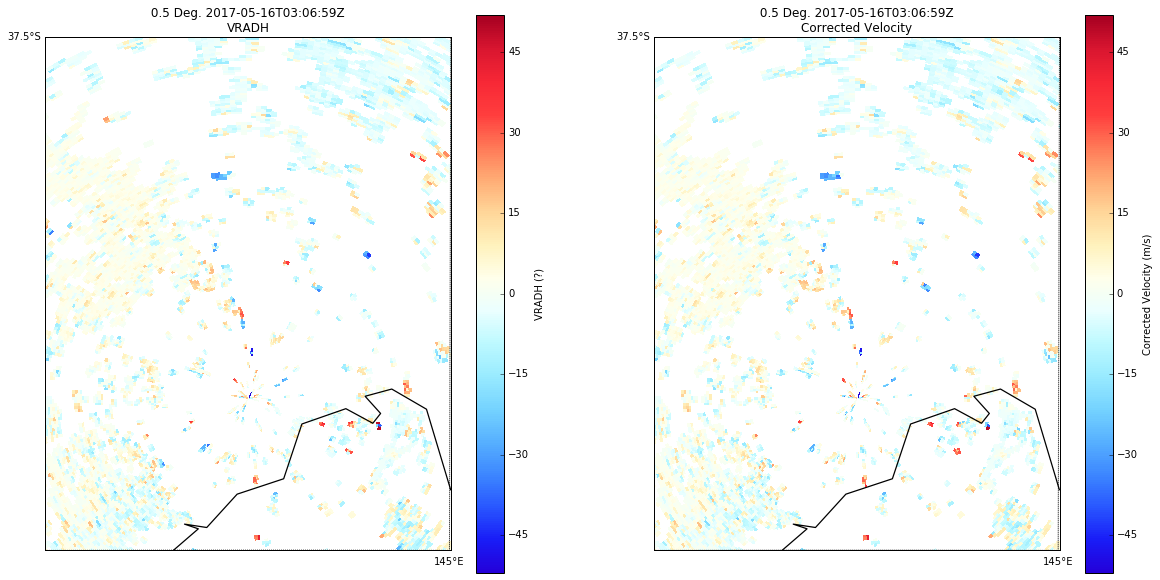

In [51]:
#init filenames
radar_fn   = '/home/meso/test_h5/02_20170516_030600.h5'

#load radar object and add prf attributes
radar = add_prf_atts(radar_fn)
#generate filtered velocity
vcorr_ma, out_mask = correct_dualPRF_cmean(radar, field='VRADH',corr_method='median', Nmin=2)

#add to radar object
radar.add_field_like('VRADH','VRADH_dualprf_corr', vcorr_ma, replace_existing = True)
radar.fields['VRADH_dualprf_corr']['standard_name'] = 'Corrected Velocity'
radar.fields['VRADH_dualprf_corr']['units'] = 'm/s'
radar.fields['VRADH_dualprf_corr']['long_name'] = 'dualPRF filtered Velocity'

#init plotting
tilt    = 0
lat_lines = np.arange(-36,-39,-.5)
lon_lines = np.arange(143, 146, .5)
max_lat   = -37.5
min_lat   = -38.0
min_lon   = 144.5
max_lon   = 145.0

#plotting
display = pyart.graph.RadarMapDisplay(radar)
f       = plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
display.plot_ppi_map('VRADH', tilt, vmin=-52, vmax=52, 
                        lat_lines = lat_lines, lon_lines = lon_lines,
                        max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                        cmap = pyart.graph.cm.BuDRd18,resolution='i')

plt.subplot(1,2,2)
display.plot_ppi_map('VRADH_dualprf_corr', tilt, vmin=-52., vmax=52., 
                        lat_lines = lat_lines, lon_lines = lon_lines,
                        max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                       cmap = pyart.graph.cm.BuDRd18,resolution='i')

ax = plt.gca()